### MLP & CNN & CIFAR-10 & Gray-Scale-CIFAR-10

#### 1. 导包


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# 检查GPU是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#### 2. RGB Data Loading and Preprocessing


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 随机裁剪
    transforms.RandomHorizontalFlip(),      # 随机水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 测试集只归一化
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# 分割数据集
trainset = torchvision.datasets.CIFAR10(root='./datasets', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./datasets', train=False,
                                       download=True, transform=transform_test)
train_size = 45000
val_size = 5000
train_subset, val_subset = torch.utils.data.random_split(
    trainset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, 
                          num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, 
                        num_workers=2, pin_memory=True)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, 
                         num_workers=2, pin_memory=True)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"训练集大小: {len(train_subset)}")
print(f"验证集大小: {len(val_subset)}")
print(f"测试集大小: {len(testset)}")

训练集大小: 45000
验证集大小: 5000
测试集大小: 10000


#### 3. 定义网络架构

In [ ]:
class FullyConnectedNet(nn.Module):
    """全连接网络"""
    def __init__(self, input_dim=3*32*32, hidden_dims=[512, 256], num_classes=10, dropout=0.5):
        super(FullyConnectedNet, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        # 展平输入: (N, C, H, W) -> (N, C*H*W)
        x = x.view(x.size(0), -1)
        return self.network(x)


class CNN(nn.Module):
    """改进的卷积神经网络 - 目标准确率90%+"""
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        
        # 第一个卷积块: 3 -> 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16
            nn.Dropout(0.2)
        )
        
        # 第二个卷积块: 64 -> 128
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8
            nn.Dropout(0.3)
        )
        
        # 第三个卷积块: 128 -> 256
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 8x8 -> 4x4
            nn.Dropout(0.4)
        )
        
        # 全连接层
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        # 权重初始化
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

#### 4. 训练框架 & 评估

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.1, 
                weight_decay=5e-4, device='cpu', model_name='Model'):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    
    # 学习率调度：特定epoch降低学习率
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }
    
    best_val_acc = 0.0
    best_epoch = 0
    
    print(f"\n{'='*70}")
    print(f"开始训练 {model_name}")
    print(f"{'='*70}\n")
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1:3d}/{num_epochs} [Train]', 
                        leave=False, ncols=100)
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            
            train_bar.set_postfix({
                'loss': f'{train_loss/train_total:.4f}',
                'acc': f'{100.*train_correct/train_total:.2f}%'
            })
        
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        
        # Validate
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), f'{model_name}_best.pth')
        
        scheduler.step()
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{num_epochs} - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    print(f"\n训练完成！")
    print(f"最佳验证准确率: {best_val_acc:.2%} (Epoch {best_epoch})")
    history['best_val_acc'] = best_val_acc
    history['best_epoch'] = best_epoch
    
    # Load the best model
    model.load_state_dict(torch.load(f'{model_name}_best.pth'))
    
    return history


def evaluate_model(model, test_loader, device='cpu'):

    model = model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    class_correct = [0] * 10
    class_total = [0] * 10
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing', ncols=100):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # 统计每个类别的准确率
            c = predicted.eq(labels)
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    test_acc = correct / total
    print(f"\n总体测试准确率: {test_acc:.2%}")
    
    print("\n各类别准确率:")
    for i in range(10):
        acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"{classes[i]:10s}: {acc:.2%} ({class_correct[i]}/{class_total[i]})")
    
    return test_acc

#### 5. 训练 MLP

In [7]:
fc_net = FullyConnectedNet(hidden_dims=[512, 256])
fc_history = train_model(
    fc_net,
    train_loader,
    val_loader,
    num_epochs=100,
    lr=0.01,
    weight_decay=5e-4,
    device=device,
    model_name='FC_Net'
)


开始训练 FC_Net



Epoch   1/100 - Train Loss: 1.9739, Train Acc: 27.77% | Val Loss: 1.7834, Val Acc: 34.66% | LR: 0.010000


Epoch  10/100 - Train Loss: 1.6402, Train Acc: 40.67% | Val Loss: 1.5161, Val Acc: 45.78% | LR: 0.010000


Epoch  20/100 - Train Loss: 1.5571, Train Acc: 43.69% | Val Loss: 1.4413, Val Acc: 48.18% | LR: 0.010000


Epoch  30/100 - Train Loss: 1.5135, Train Acc: 45.48% | Val Loss: 1.4111, Val Acc: 49.04% | LR: 0.010000


Epoch  40/100 - Train Loss: 1.4903, Train Acc: 46.23% | Val Loss: 1.3843, Val Acc: 50.22% | LR: 0.010000


Epoch  50/100 - Train Loss: 1.4796, Train Acc: 47.00% | Val Loss: 1.3559, Val Acc: 51.20% | LR: 0.001000


Epoch  60/100 - Train Loss: 1.4288, Train Acc: 48.65% | Val Loss: 1.3314, Val Acc: 52.06% | LR: 0.001000


Epoch  70/100 - Train Loss: 1.4128, Train Acc: 49.58% | Val Loss: 1.3120, Val Acc: 53.54% | LR: 0.001000


Epoch  80/100 - Train Loss: 1.4073, Train Acc: 49.50% | Val Loss: 1.3037, Val Acc: 53.74% | LR: 0.000100


Epoch  90/100 - Train Loss: 1.4027, Train Acc: 49.55% | Val Loss: 1.3072, Val Acc: 53.32% | LR: 0.000100


Epoch 100/100 - Train Loss: 1.4026, Train Acc: 49.66% | Val Loss: 1.3122, Val Acc: 52.84% | LR: 0.000100

训练完成！
最佳验证准确率: 53.90% (Epoch 88)


#### 6. 训练CNN

In [ ]:
cnn_net = ImprovedCNN()
cnn_history = train_model(
    cnn_net,
    train_loader,
    val_loader,
    num_epochs=100,
    lr=0.1,
    weight_decay=5e-4,
    device=device,
    model_name='CNN_Net'
)


开始训练 CNN_Net



Epoch   1/100 - Train Loss: 1.9571, Train Acc: 36.34% | Val Loss: 1.3573, Val Acc: 50.42% | LR: 0.100000


Epoch  10/100 - Train Loss: 0.6477, Train Acc: 78.14% | Val Loss: 0.6655, Val Acc: 77.12% | LR: 0.100000


Epoch  20/100 - Train Loss: 0.5601, Train Acc: 80.97% | Val Loss: 0.6101, Val Acc: 78.90% | LR: 0.100000


Epoch  30/100 - Train Loss: 0.5368, Train Acc: 81.68% | Val Loss: 0.5997, Val Acc: 80.50% | LR: 0.100000


Epoch  40/100 - Train Loss: 0.5210, Train Acc: 82.47% | Val Loss: 0.5601, Val Acc: 80.56% | LR: 0.100000


Epoch  50/100 - Train Loss: 0.5086, Train Acc: 82.72% | Val Loss: 0.5402, Val Acc: 81.18% | LR: 0.010000


Epoch  60/100 - Train Loss: 0.2382, Train Acc: 92.14% | Val Loss: 0.2512, Val Acc: 91.32% | LR: 0.010000


Epoch  70/100 - Train Loss: 0.2007, Train Acc: 93.07% | Val Loss: 0.2615, Val Acc: 90.98% | LR: 0.010000


Epoch  80/100 - Train Loss: 0.1427, Train Acc: 95.18% | Val Loss: 0.2298, Val Acc: 92.20% | LR: 0.001000


Epoch  90/100 - Train Loss: 0.1225, Train Acc: 96.00% | Val Loss: 0.2277, Val Acc: 92.22% | LR: 0.001000


Epoch 100/100 - Train Loss: 0.1175, Train Acc: 95.98% | Val Loss: 0.2115, Val Acc: 93.12% | LR: 0.001000

训练完成！
最佳验证准确率: 93.12% (Epoch 99)


#### 7. 可视化

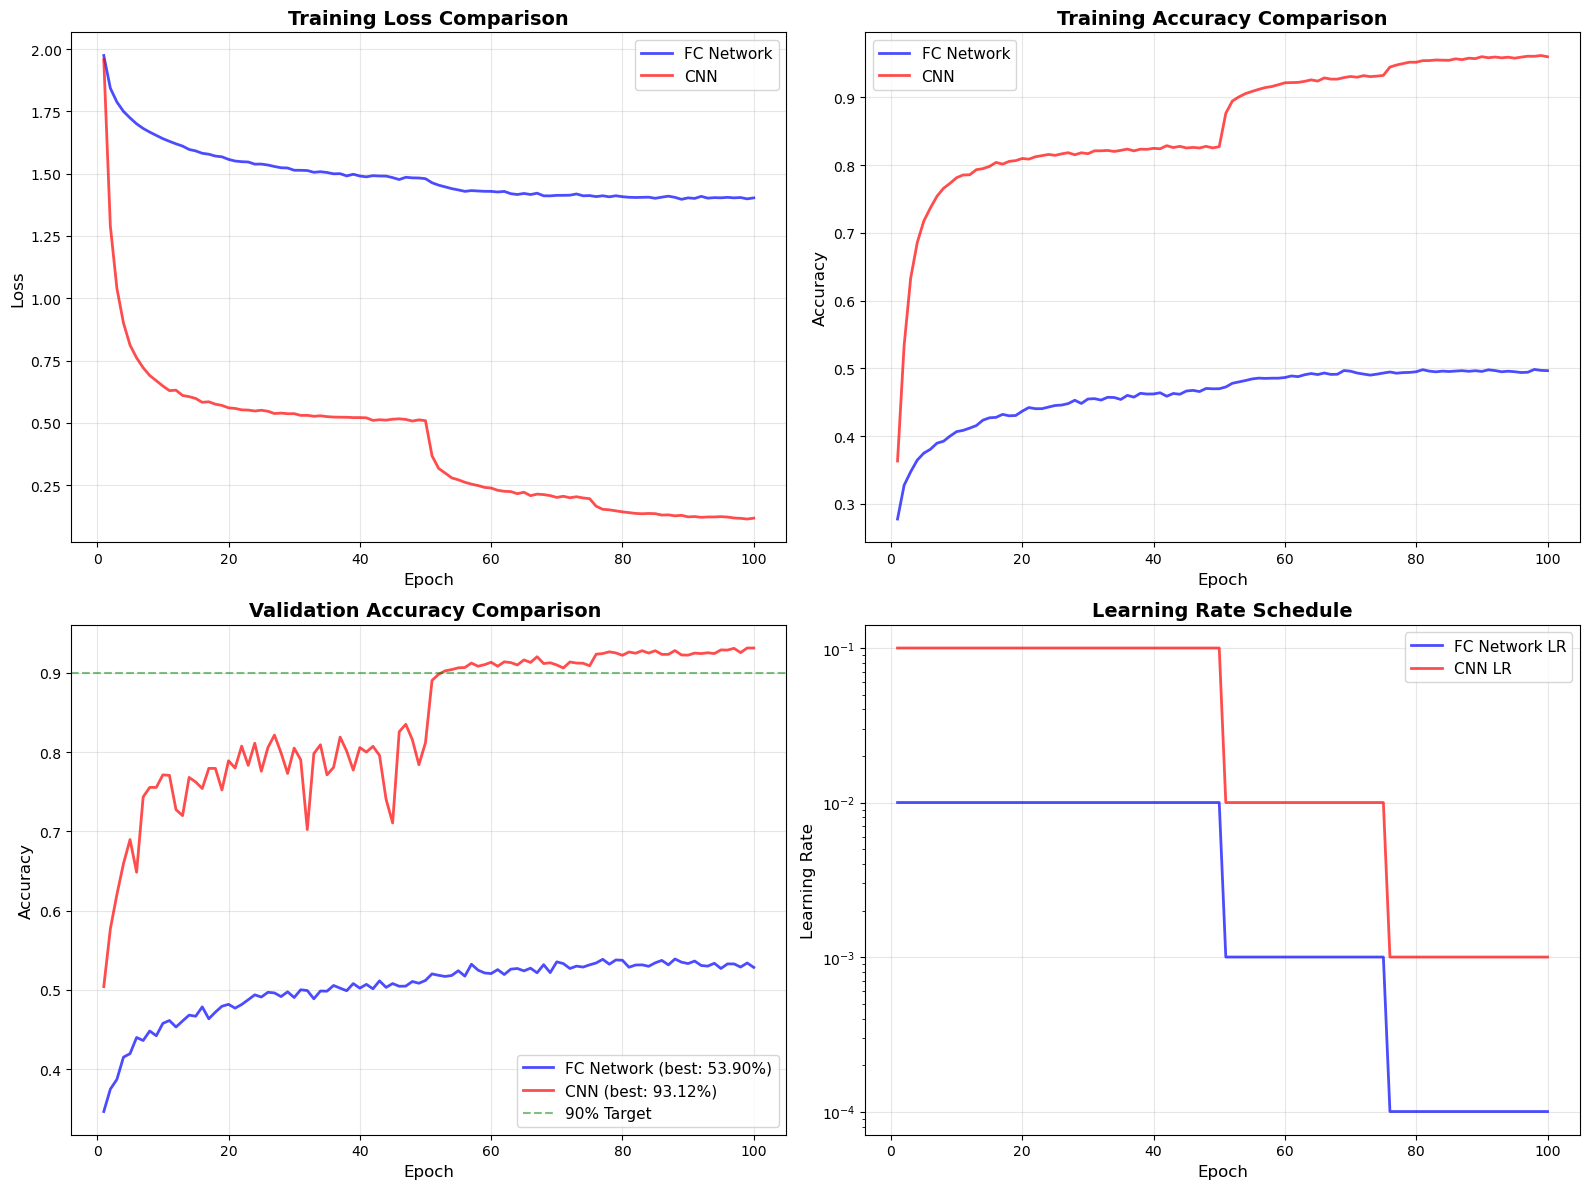

训练曲线已保存为 'training_comparison.png'


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs_range = range(1, len(fc_history['train_loss']) + 1)

# 损失对比
axes[0, 0].plot(epochs_range, fc_history['train_loss'], 'b-', alpha=0.7, label='FC Network', linewidth=2)
axes[0, 0].plot(epochs_range, cnn_history['train_loss'], 'r-', alpha=0.7, label='CNN', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 准确率对比
axes[0, 1].plot(epochs_range, fc_history['train_acc'], 'b-', alpha=0.7, label='FC Network', linewidth=2)
axes[0, 1].plot(epochs_range, cnn_history['train_acc'], 'r-', alpha=0.7, label='CNN', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 验证准确率对比
axes[1, 0].plot(epochs_range, fc_history['val_acc'], 'b-', alpha=0.7, 
                label=f'FC Network (best: {fc_history["best_val_acc"]:.2%})', linewidth=2)
axes[1, 0].plot(epochs_range, cnn_history['val_acc'], 'r-', alpha=0.7, 
                label=f'CNN (best: {cnn_history["best_val_acc"]:.2%})', linewidth=2)
axes[1, 0].axhline(y=0.9, color='g', linestyle='--', alpha=0.5, label='90% Target')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy', fontsize=12)
axes[1, 0].set_title('Validation Accuracy Comparison ', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# 学习率调度
axes[1, 1].plot(epochs_range, fc_history['lr'], 'b-', alpha=0.7, label='FC Network LR', linewidth=2)
axes[1, 1].plot(epochs_range, cnn_history['lr'], 'r-', alpha=0.7, label='CNN LR', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("训练曲线已保存为 'training_comparison.png'")

#### 8. test

In [ ]:
fc_test_acc = evaluate_model(fc_net, test_loader, device)
cnn_test_acc = evaluate_model(cnn_net, test_loader, device)

print(f"MLP - 验证准确率: {fc_history['best_val_acc']:.2%}, 测试准确率: {fc_test_acc:.2%}")
print(f"CNN - 验证准确率: {cnn_history['best_val_acc']:.2%}, 测试准确率: {cnn_test_acc:.2%}")

#### 9. 性能对比

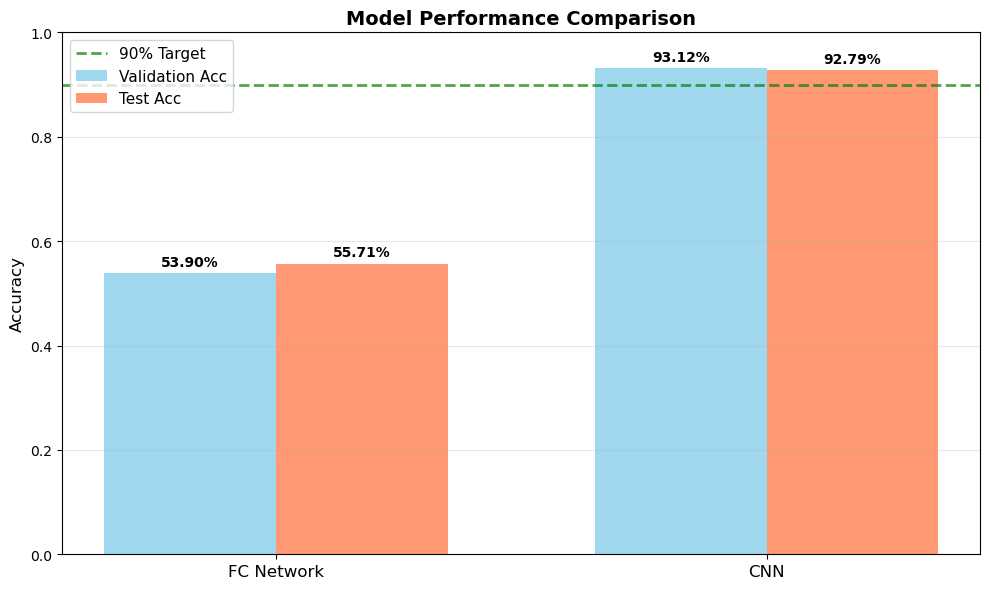

性能对比图已保存为 'performance_comparison.png'


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

models_names = ['FC Network', 'CNN']
val_accs = [fc_history['best_val_acc'], cnn_history['best_val_acc']]
test_accs = [fc_test_acc, cnn_test_acc]

x = np.arange(len(models_names))
width = 0.35

bars1 = ax.bar(x - width/2, val_accs, width, label='Validation Acc', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, test_accs, width, label='Test Acc', alpha=0.8, color='coral')

ax.axhline(y=0.9, color='green', linestyle='--', linewidth=2, alpha=0.7, label='90% Target')

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models_names, fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.0])

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

#### 10. 可视化CNN第一层卷积核

In [ ]:
def visualize_conv_filters(model, layer_name='conv1', num_filters=64):
    # 获取第一个卷积层的权重
    conv_layer = model.conv1[0]  # conv1是Sequential，取第一个Conv2d
    conv_weight = conv_layer.weight.data.cpu().numpy()
    
    num_filters_to_show = min(num_filters, conv_weight.shape[0])
    F, C, HH, WW = conv_weight.shape
    
    # 归一化权重
    w_min, w_max = conv_weight.min(), conv_weight.max()
    weights_norm = (conv_weight - w_min) / (w_max - w_min + 1e-8)
    
    grid_size = int(np.ceil(np.sqrt(num_filters_to_show)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(num_filters_to_show):
        if C == 3:
            filter_img = weights_norm[i].transpose(1, 2, 0)
        else: 
            filter_img = weights_norm[i, 0]
        
        axes[i].imshow(filter_img, cmap='gray' if C == 1 else None)
        axes[i].axis('off')
        axes[i].set_title(f'Filter {i+1}', fontsize=8)
    
    for i in range(num_filters_to_show, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('CNN first layer learned filters', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('conv_filters.png', dpi=150, bbox_inches='tight')
    plt.show()

# 
visualize_conv_filters(cnn_net, num_filters=64)

#### 11. 特征图

In [ ]:
def visualize_feature_maps(model, image, label, class_name, num_maps=32):
    model.eval()
    
    # 第一个卷积块的输出
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)
        feature_maps = model.conv1(x)
        feature_maps = feature_maps.cpu().numpy()[0]
    
    num_filters = feature_maps.shape[0]
    num_show = min(num_maps, num_filters)

    cols = 8
    rows = (num_show + cols - 1) // cols + 1  # +1 for the original image
    
    fig = plt.figure(figsize=(16, rows * 2))
    
    # 显示原始图像
    plt.subplot(rows, cols, 1)
    img_show = image.cpu().numpy()
    img_show = img_show / 2 + 0.5  # 反归一化
    img_show = np.transpose(img_show, (1, 2, 0))
    img_show = np.clip(img_show, 0, 1)
    plt.imshow(img_show)
    plt.title(f'Input\n{class_name}', fontsize=10, fontweight='bold')
    plt.axis('off')
    
    # 显示特征图
    for i in range(num_show):
        plt.subplot(rows, cols, i + 2)
        feature_map = feature_maps[i]
        plt.imshow(feature_map, cmap='viridis')
        plt.title(f'FM {i+1}', fontsize=8)
        plt.axis('off')
    
    plt.suptitle('CNN Feature Maps', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('feature_maps.png', dpi=150, bbox_inches='tight')
    plt.show()

# 一个测试样本
test_iter = iter(test_loader)
test_images, test_labels = next(test_iter)
sample_idx = 0
sample_img = test_images[sample_idx]
sample_label = test_labels[sample_idx].item()

visualize_feature_maps(cnn_net, sample_img, sample_label, classes[sample_label])

#### 12. Grayscale-CIFAR-10


In [ ]:
class GrayscaleTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    
    def __call__(self, img):
        # 转换为灰度
        img = transforms.functional.to_grayscale(img, num_output_channels=1)
        return self.base_transform(img)


# 灰度数据的预处理和增强
transform_train_gray = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4734,), (0.2516,)),  # 灰度CIFAR-10的统计值
])

transform_test_gray = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4734,), (0.2516,)),
])

# 加载gray_CIFAR-10
class CIFAR10Grayscale(torchvision.datasets.CIFAR10):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        return img, target

# 数据集划分
trainset_gray = torchvision.datasets.CIFAR10(
    root='./datasets', train=True, download=False,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=1),  # 转灰度
        transforms.ToTensor(),
        transforms.Normalize((0.4734,), (0.2516,)),
    ])
)

testset_gray = torchvision.datasets.CIFAR10(
    root='./datasets', train=False, download=False,
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # 转灰度
        transforms.ToTensor(),
        transforms.Normalize((0.4734,), (0.2516,)),
    ])
)

train_size = 45000
val_size = 5000
train_subset_gray, val_subset_gray = torch.utils.data.random_split(
    trainset_gray, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# 创建灰度数据的DataLoader
train_loader_gray = DataLoader(train_subset_gray, batch_size=128, shuffle=True,
                               num_workers=2, pin_memory=True)
val_loader_gray = DataLoader(val_subset_gray, batch_size=128, shuffle=False,
                             num_workers=2, pin_memory=True)
test_loader_gray = DataLoader(testset_gray, batch_size=128, shuffle=False,
                              num_workers=2, pin_memory=True)

print("灰度图像数据加载完成！")
print(f"灰度训练集大小: {len(train_subset_gray)}")
print(f"灰度验证集大小: {len(val_subset_gray)}")
print(f"灰度测试集大小: {len(testset_gray)}")


灰度图像数据加载完成！
灰度训练集大小: 45000
灰度验证集大小: 5000
灰度测试集大小: 10000


#### 13. gray & 网络架构

In [ ]:
class FCNet_Gray(nn.Module):
    def __init__(self, input_dim=1*32*32, hidden_dims=[512, 256], num_classes=10, dropout=0.5):
        super(FCNet_Gray, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, num_classes))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)


class CNN_Gray(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Gray, self).__init__()
        
        # 第一个卷积块: 1 -> 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # 1个输入通道
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2)
        )
        
        # 第二个卷积块: 64 -> 128
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )
        
        # 第三个卷积块: 128 -> 256
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


#### 14. FCNET & CNN - Grayscale 训练


In [ ]:
fc_net_gray = FCNet_Gray(hidden_dims=[512, 256])
fc_history_gray = train_model(
    fc_net_gray,
    train_loader_gray,
    val_loader_gray,
    num_epochs=100,
    lr=0.01,
    weight_decay=5e-4,
    device=device,
    model_name='FC_Net_Gray'
)

cnn_net_gray = CNN_Gray()
cnn_history_gray = train_model(
    cnn_net_gray,
    train_loader_gray,
    val_loader_gray,
    num_epochs=100,
    lr=0.1,
    weight_decay=5e-4,
    device=device,
    model_name='CNN_Net_Gray'
)



print("灰度全连接网络测试结果")
fc_test_acc_gray = evaluate_model(fc_net_gray, test_loader_gray, device)

print("灰度CNN测试结果")
cnn_test_acc_gray = evaluate_model(cnn_net_gray, test_loader_gray, device)


#### 15. 最终比较


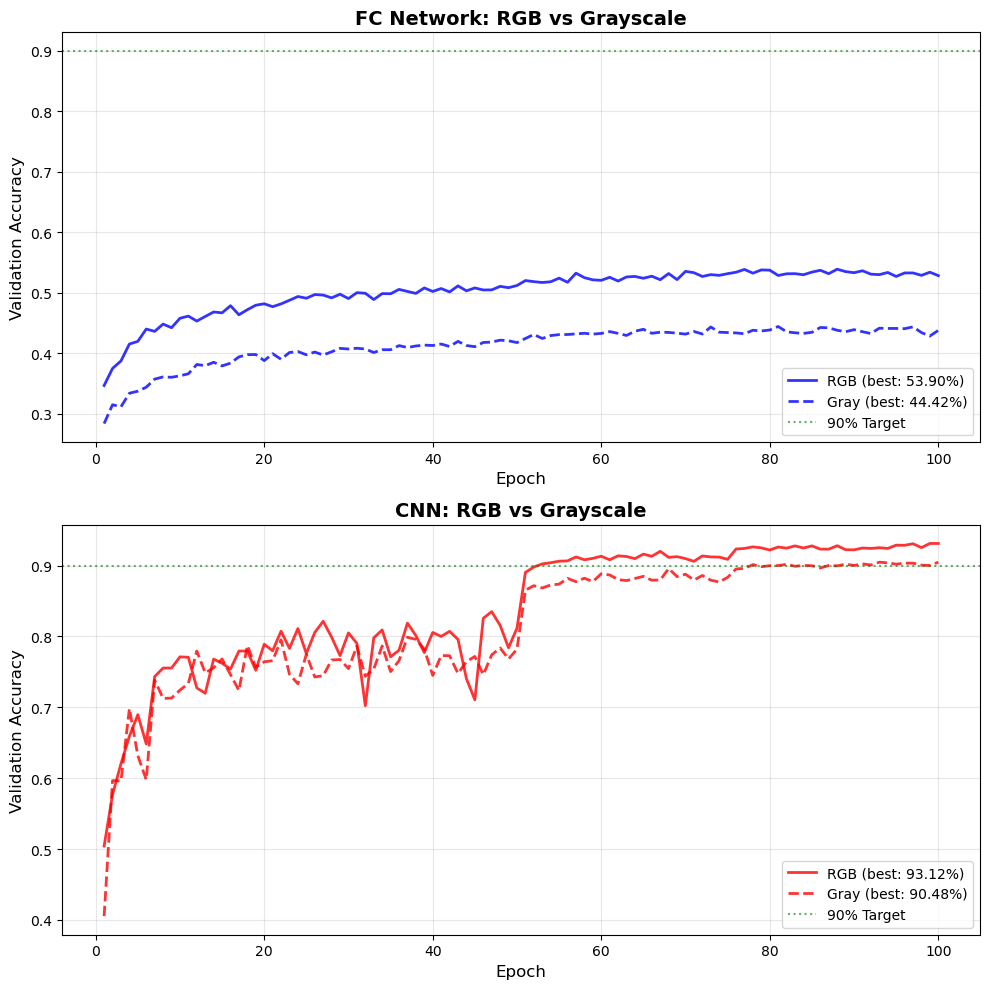

已绘制：rgb_vs_gray_two_curves.png


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

epochs_range = range(1, len(fc_history['train_loss']) + 1)

# FC 验证率曲线
axes[0].plot(epochs_range, fc_history['val_acc'], 'b-', alpha=0.8,
             label=f'RGB (best: {fc_history["best_val_acc"]:.2%})', linewidth=2)
axes[0].plot(epochs_range, fc_history_gray['val_acc'], 'b--', alpha=0.8,
             label=f'Gray (best: {fc_history_gray["best_val_acc"]:.2%})', linewidth=2)

axes[0].axhline(y=0.9, color='g', linestyle=':', alpha=0.6, label='90% Target')

axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Validation Accuracy', fontsize=12)
axes[0].set_title('FC Network: RGB vs Grayscale', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# CNN 验证率曲线
axes[1].plot(epochs_range, cnn_history['val_acc'], 'r-', alpha=0.8,
             label=f'RGB (best: {cnn_history["best_val_acc"]:.2%})', linewidth=2)
axes[1].plot(epochs_range, cnn_history_gray['val_acc'], 'r--', alpha=0.8,
             label=f'Gray (best: {cnn_history_gray["best_val_acc"]:.2%})', linewidth=2)

axes[1].axhline(y=0.9, color='g', linestyle=':', alpha=0.6, label='90% Target')

axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Accuracy', fontsize=12)
axes[1].set_title('CNN: RGB vs Grayscale', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rgb_vs_gray_two_curves.png', dpi=150, bbox_inches='tight')
plt.show()